<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

# Graphs tutorial

In this activity we are going to explore how we can build, manipulate and search graphs. 

We use the [`networkx`][networkx] library for dealing with graphs.

[networkx]: https://networkx.github.io

In [14]:
import networkx as nx

Another tutorial is available [here](https://networkx.github.io/documentation/stable/tutorial.html).


# Adding nodes and edges

Use the class `MultiDiGraph` to create a directed graph with multiple edges and self-loops.

In [15]:
G = nx.DiGraph() # Directed
G = nx.MultiDiGraph()

Add nodes using `add_node`:

In [16]:
G.add_node('node1')
G.add_node('node2')
G.add_node('node3')

Check that a node is in the graph:

In [17]:
assert 'node1' in G

Get all nodes:

In [18]:
list(G.nodes())

['node1', 'node2', 'node3']

Add some edges:

In [19]:
G.add_edge('node1', 'node2');

Nodes get automatically added:

In [20]:
G.add_edge('node2', 'another1');
G.add_edge('another1', 'another2');

List edges:

In [21]:
# list of 2-tuples (from, to)
list(G.edges())

[('node1', 'node2'), ('node2', 'another1'), ('another1', 'another2')]

In [22]:
for a,b in G.edges():
    print('edge from %s to %s' % (a, b))

edge from node1 to node2
edge from node2 to another1
edge from another1 to another2


## Drawing graphs

There are some minimal plotting capabilities.

In [23]:
def draw_graph(G0, pos=None):
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    ax = plt.gca()
    nx.draw(G0,pos=pos,labels={node:node for node in G0.nodes()})
    #nx.draw(G0,labels={node:node for node in G0.nodes()})
    def edge_label(a, b):
        datas = G0.get_edge_data(a, b)
        s = '%d edge%s' % (len(datas), 's' if len(datas)>=2 else '')
        for k, v in datas.items():
            if v:
                if 'label' in v:
                    s += '\n %s' % v['label']
                else:
                    s += '\n %s' %v
        return s
    edge_labels = dict([ ((a,b), edge_label(a,b)) for a,b in G0.edges()])
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=edge_labels,font_color='red')
    plt.axis('off')
    plt.show()

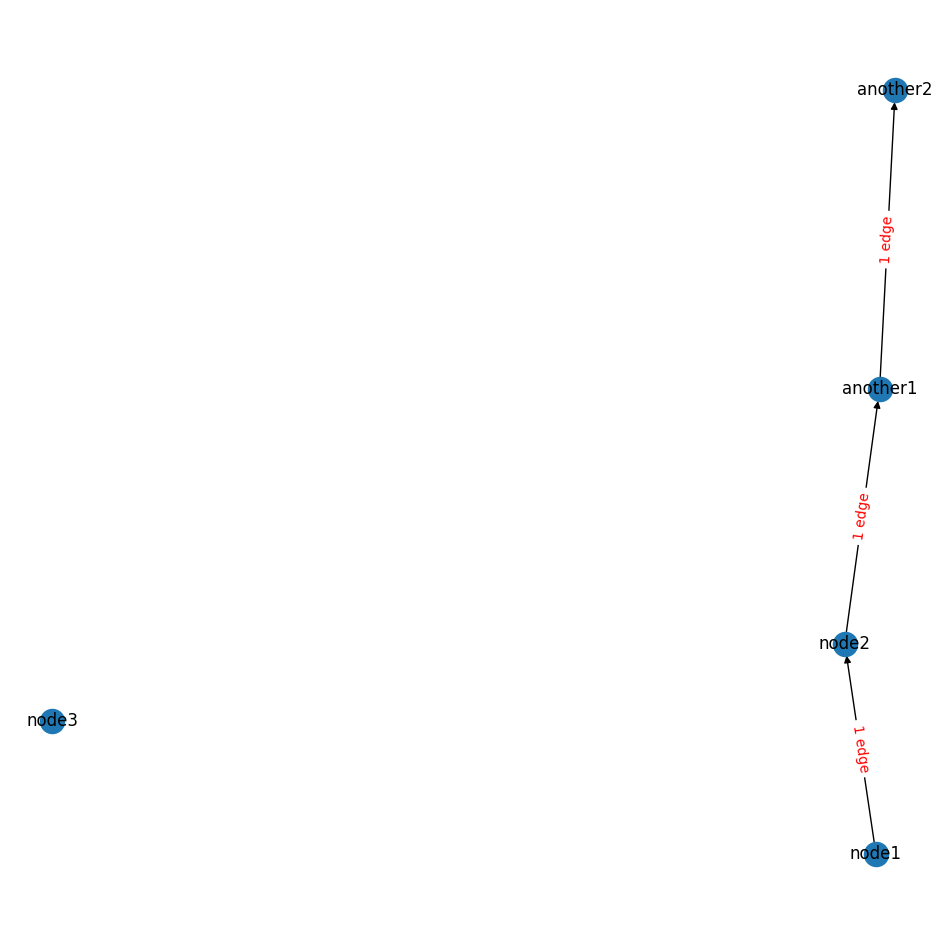

In [24]:
draw_graph(G)

## Multiple edges

You can add a second edge between the nodes:

In [25]:
G.add_edge('node1', 'node2');

Notice now how there are two copies of the same edge:

In [26]:
list(G.edges())

[('node1', 'node2'),
 ('node1', 'node2'),
 ('node2', 'another1'),
 ('another1', 'another2')]

Multiple edges in the graph:

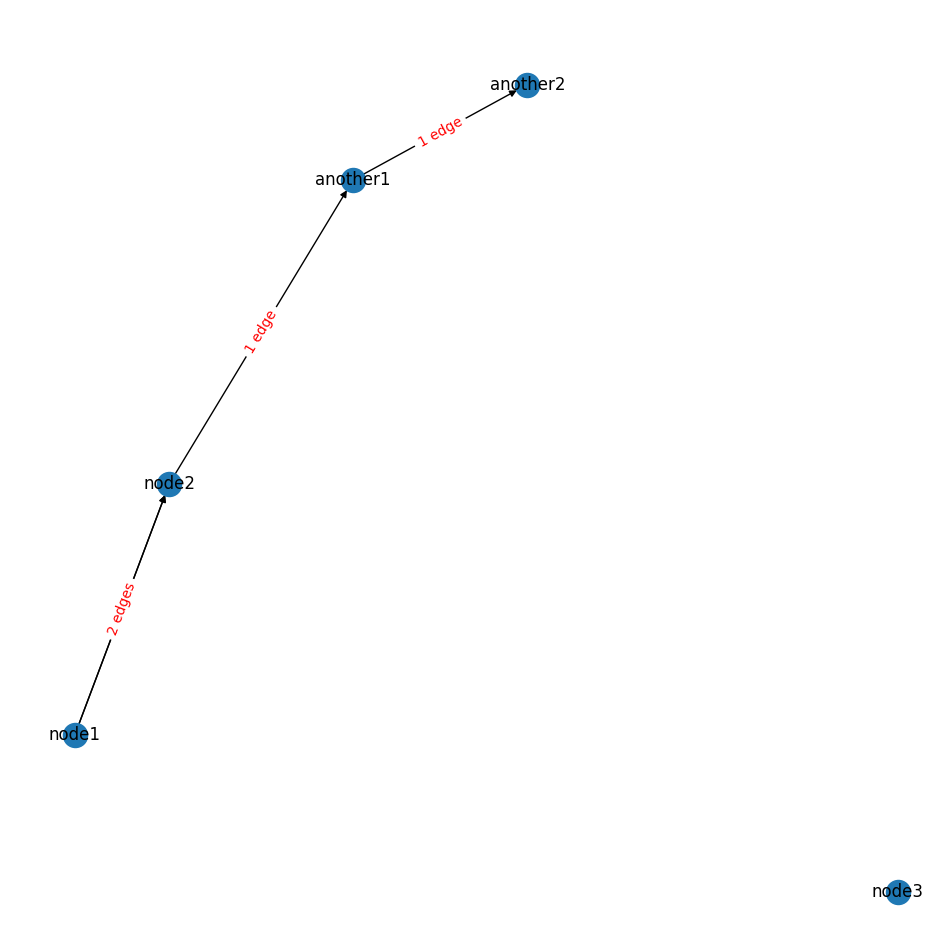

In [27]:
draw_graph(G)

## Attaching data to edges

You can use the optional parameters of the `add_edge` method to attach some pieces of data.

For example we add two more edges between `node1` and `node4` with property `prop` set to 12 and 15.

In [28]:
G.add_edge('node1', 'node4',  prop=12);
G.add_edge('node1', 'node4',  prop=15);

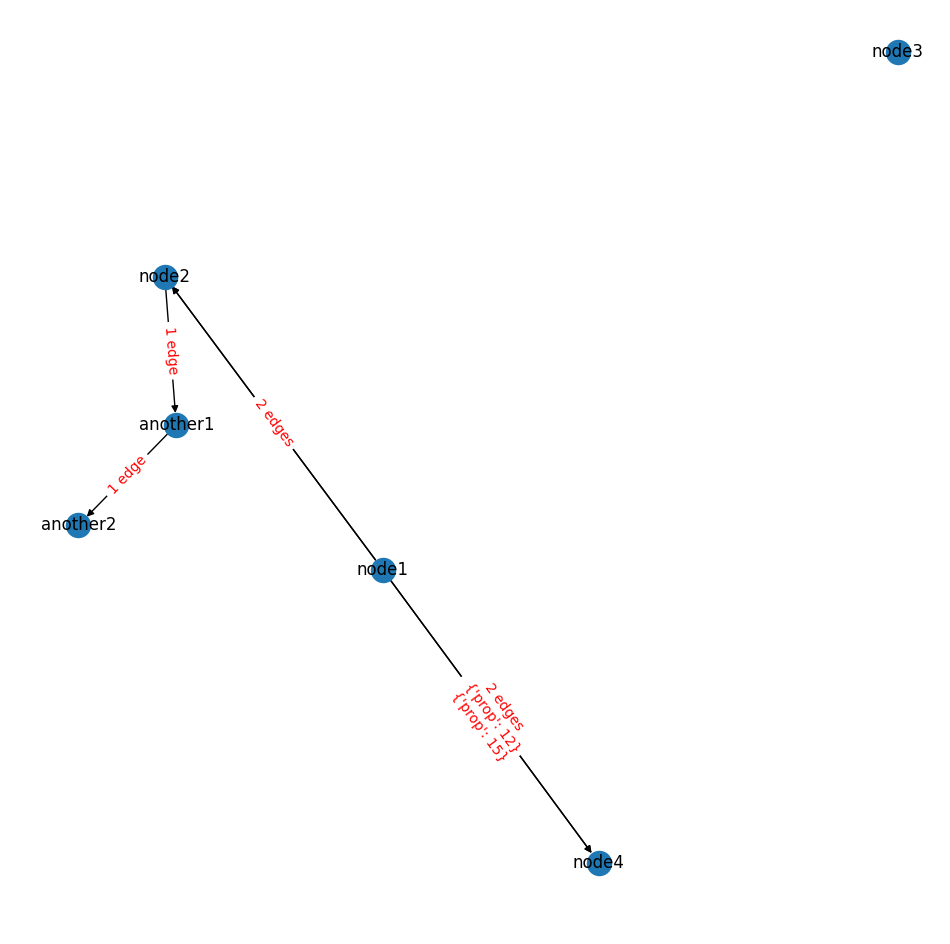

In [29]:
draw_graph(G)

Using the function `get_edge_data` we can get the data attached to the edge.
The function returns a dictionary 'edge-label -> properties', where `edge-label` is just an integer.

In [30]:
data = G.get_edge_data('node1', 'node4');
print(data)

{0: {'prop': 12}, 1: {'prop': 15}}


In [31]:
for id_edge, edge_data in data.items():
    print('edge %s: attribute  prop = %s' % (id_edge, edge_data['prop']))

edge 0: attribute  prop = 12
edge 1: attribute  prop = 15


## Querying the graph

Concepts:

- neighbors: all nodes to which a node N connects
- predecessors: all nodes connected to N
- ancestors (transitive closure of predecessors)
- successors
- descendants (transitive closure of successors)

In [32]:
list(G.predecessors('node2'))

['node1']

In [33]:
list(nx.ancestors(G, 'another2'))

['node2', 'another1', 'node1']

In [34]:
list(G.successors('node2'))

['another1']

In [35]:
list(nx.descendants(G, 'node2'))

['another2', 'another1']

## Cycles

Use the function `nx.simple_cycles` to get the cycles in the graph:

In [36]:
list(nx.simple_cycles(G))

[]

Let's create a more interesting graph:

In [37]:
G2 = nx.MultiDiGraph()
edges = [
    ('A', 'B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('E', 'F'),
    ('F', 'A'),
    
    ('A', 'G'),
    ('G', 'H'),
    ('H', 'A')]
G2.add_edges_from(edges);

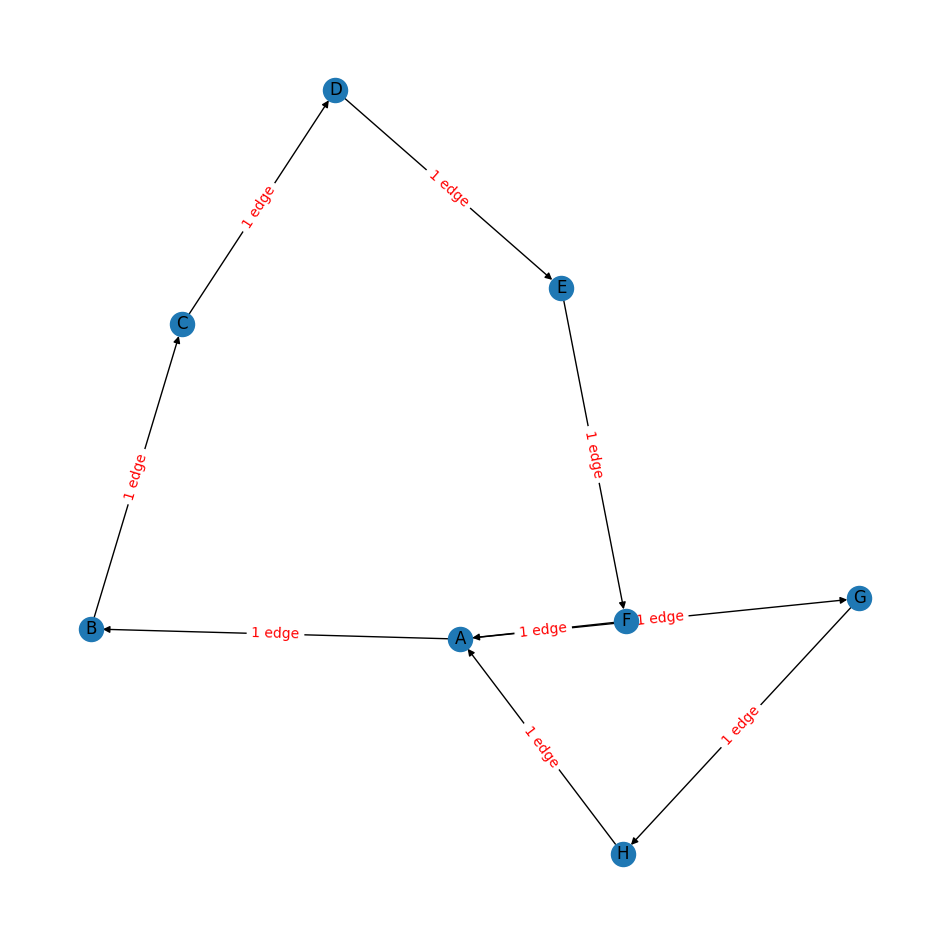

In [38]:
draw_graph(G2)

The function returns a list of lists:

In [39]:
list(nx.simple_cycles(G2))

[['B', 'C', 'D', 'E', 'F', 'A'], ['H', 'A', 'G']]

## Paths

Use `has_path` to check that two nodes are connected:

In [40]:
nx.has_path(G2, 'A', 'C')

True

In [41]:
nx.has_path(G2, 'C', 'A')

True

But what are these paths? Use `nx.shortest_path` to find out:

In [42]:
nx.shortest_path(G2, 'A', 'C')

['A', 'B', 'C']

In [43]:
nx.shortest_path(G2, 'C', 'A')

['C', 'D', 'E', 'F', 'A']

## Attaching data to nodes

Use kwargs of `add_node` to add attributes to nodes:

In [44]:
M = nx.DiGraph()
M.add_node('a', q=2)

Get it back using this syntax: 

In [45]:
M.nodes['a']

{'q': 2}

## Example: pose network

We create a *pose network*: a graph where each node represents a pose
and each edge is a measurement.

Let's create a grid-like network:

In [46]:
H, W = 4, 4
grid_size = 0.61

In [47]:
import itertools
import geometry as geo
M = nx.MultiDiGraph()
for i, j in itertools.product(range(H), range(W)):
    # node name is a tuple 
    node_name = (i, j)
    # create a pose 
    q = geo.SE2_from_translation_angle((i*grid_size, j*grid_size), 0)
    M.add_node(node_name, q=q) # q as property

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.8/dist-packages


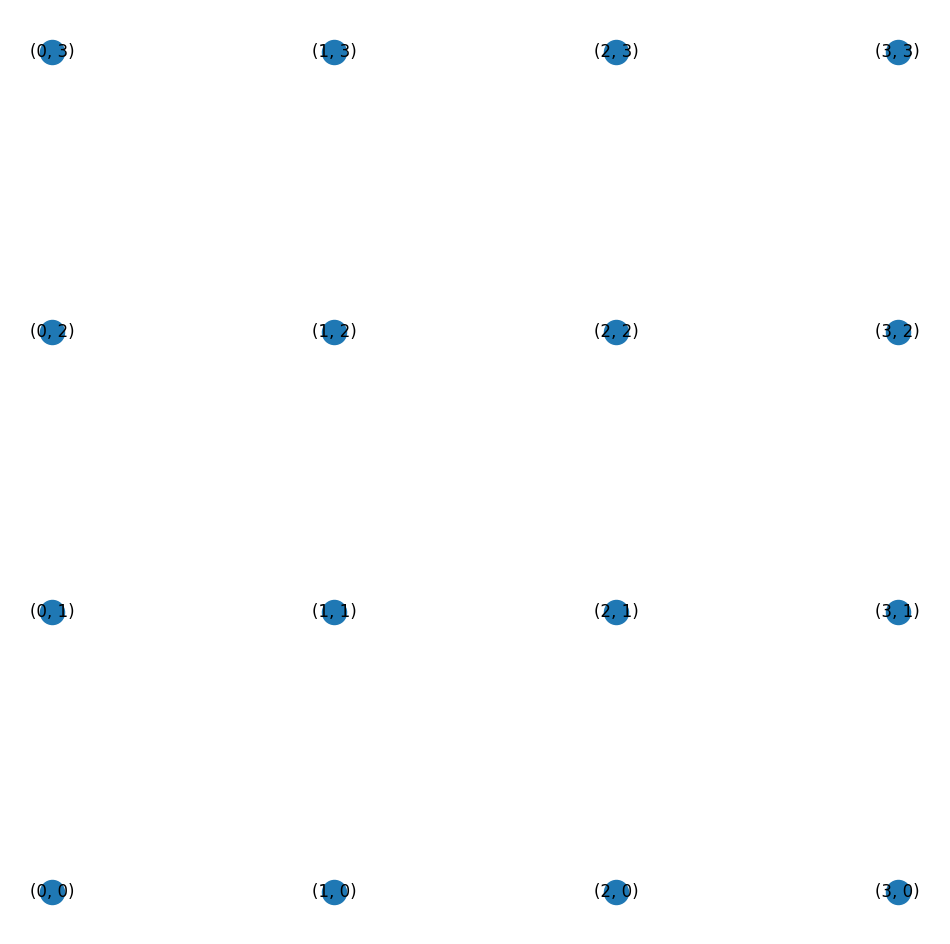

In [48]:
# let's plot them where they are supposed to go
def position_for_node(node):
    # node is a tuple (i,j)
    # query the node properties
    properties = M.nodes[node]
    # get the pose set before
    q = properties['q']
    # extract the translation 
    t, _ = geo.translation_angle_from_SE2(q)
    # that's my position
    return t

pos = dict([(node, position_for_node(node)) for node in M])

draw_graph(M, pos=pos)

Now let's create the network connections:

In [49]:
geo.SE2.friendly(geo.SE2.identity())

'Pose(Rot(0.0deg),[0. 0.])'

In [50]:
for i, j in itertools.product(range(H), range(W)):
    # for each node
    
    # connect to neighbors
    for d in [ (+1, 0), (0, +1), (+1,+1)]:
        # neighbors coordinatex
        i2, j2 = i+d[0], j+d[1]
        # if neighbor exists
        if (i2,j2) in M:
            # add the connection
            
            # pose of the first node
            q1 = M.nodes[(i,j)]['q']
            # pose of the second node
            q2 = M.nodes[(i2,j2)]['q']
            # relative pose 
            relative_pose = geo.SE2.multiply(geo.SE2.inverse(q1), q2)
            # label 
            label = geo.SE2.friendly(relative_pose)
            # add the edge with two properties "label" and "relative_pose"
            M.add_edge( (i,j), (i2,j2), label=label, relative_pose=relative_pose)
            

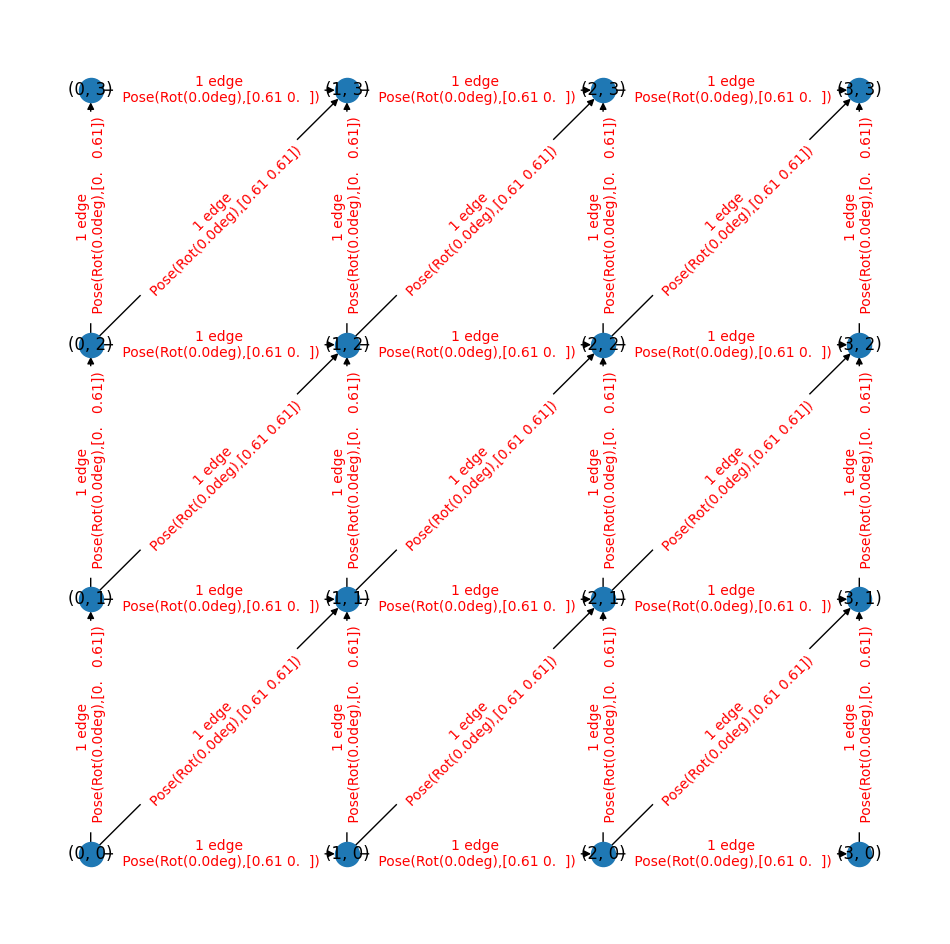

In [51]:
draw_graph(M, pos=pos)

Now let's find the relative position between two nodes using the graph functions. 


In [52]:
# let's add inverse edges 
for node1, node2 in M.edges():
    for id_edge, edge_data in M.get_edge_data(node1, node2).items():
        r = edge_data['relative_pose']
        rinv = geo.SE2.inverse(r)
        label = geo.SE2.friendly(rinv)
        M.add_edge(node2, node1, relative_pose=rinv, label=label)


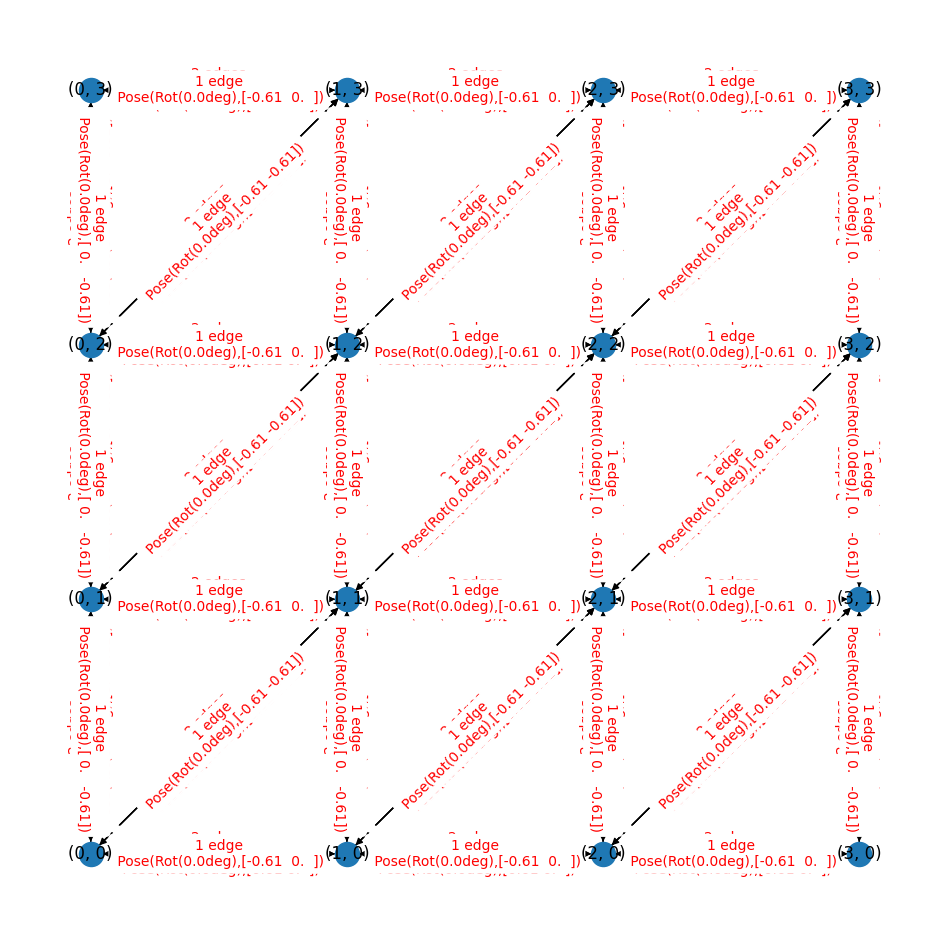

In [53]:
draw_graph(M, pos=pos)

In [54]:
node1, node2 = (1,3), (2,1)

In [55]:
path = nx.shortest_path(M, node1, node2)
print(path)

[(1, 3), (2, 3), (2, 2), (2, 1)]


Get the edges from this sequence of nodes:

In [56]:
zip(path[1:], path[:-1])

In [57]:
edges = list(zip(path[1:],path[:-1]))
for a, b in edges:
    print('edge from %s to %s' % (a,b ))

edge from (2, 3) to (1, 3)
edge from (2, 2) to (2, 3)
edge from (2, 1) to (2, 2)


We can recover the relative pose using `get_edge_data`:

In [58]:
deltas = []
for a, b in edges:
    R = M.get_edge_data(a, b)[0]['relative_pose']
    deltas.append(R)
    print('edge %s to %s: relative pose: %s' % (a, b, geo.SE2.friendly(R)))
print(deltas)

edge (2, 3) to (1, 3): relative pose: Pose(Rot(0.0deg),[-0.61  0.  ])
edge (2, 2) to (2, 3): relative pose: Pose(Rot(0.0deg),[0.   0.61])
edge (2, 1) to (2, 2): relative pose: Pose(Rot(0.0deg),[0.   0.61])
[array([[ 1.  ,  0.  , -0.61],
       [ 0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ]]), array([[1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.61],
       [0.  , 0.  , 1.  ]]), array([[1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.61],
       [0.  , 0.  , 1.  ]])]


In [59]:
def multiply_deltas(G, deltas):
    S = geo.SE2.identity()
    for R in deltas:
        S = geo.SE2.multiply(S, R) # multiply on the right 
    return S

In [60]:
S = multiply_deltas(M, deltas)
print(geo.SE2.friendly(S))

Pose(Rot(0.0deg),[-0.61  1.22])


Now proceed to the [planning exercise](../02-Path-Planner/planning02.ipynb).